In [11]:
import sys
assert sys.version_info >= (3, 5)

# 사이킷런 ≥0.20 필수
import sklearn
assert sklearn.__version__ >= "0.20"

# 공통 모듈 임포트
import numpy as np
import os

np.random.seed(42)

%matplotlib inline
import matplotlib as mpl
import matplotlib.pyplot as plt
mpl.rc('axes', labelsize=14)
mpl.rc('xtick', labelsize=12)
mpl.rc('ytick', labelsize=12)

PROJECT_ROOT_DIR = "."
CHAPTER_ID = "ensembles"
IMAGES_PATH = os.path.join(PROJECT_ROOT_DIR, "images", CHAPTER_ID)
os.makedirs(IMAGES_PATH, exist_ok=True)

def save_fig(fig_id, tight_layout=True, fig_extension="png", resolution=300):
    path = os.path.join(IMAGES_PATH, fig_id + "." + fig_extension)
    print("그림 저장:", fig_id)
    if tight_layout:
        plt.tight_layout()
    plt.savefig(path, format=fig_extension, dpi=resolution)

# 앙상블 학습과 랜덤 포레스트

- 배깅, 부스팅, 스태킹 등 가장 인기있는 앙상블 방법에 대해서 학습
- 추가로, 랜덤 포레스트도 학습

# 투표 기반 분류기 
- 정확도 80%의 분류기 여러 개를 훈련시켰다고 가정
 - ex. 로지스틱 회귀 분류기, SVM 분류기, 랜덤 포레스트 분류기, K-NN 분류기 등

- 이 때, 더 좋은 분류기를 만드는 매우 간단한 방법은 각 분류기의 예측을 모아서 가장 많이 선택된 클래스를 예측하는 것
- 이렇게 다수결 투표로 정해지는 분류기를 직접 투표 분류기라고 함

In [12]:
heads_proba = 0.51
coin_tosses = (np.random.rand(10000,10) < heads_proba).astype(np.int32) # 앞면이 나올 확률 51%, 뒷면 49%라고 가정
cumulative_heads_ratio = np.cumsum(coin_tosses, axis = 0) / np.arange(1,10001).reshape(-1,1)

그림 저장: law_of_large_numbers_plot


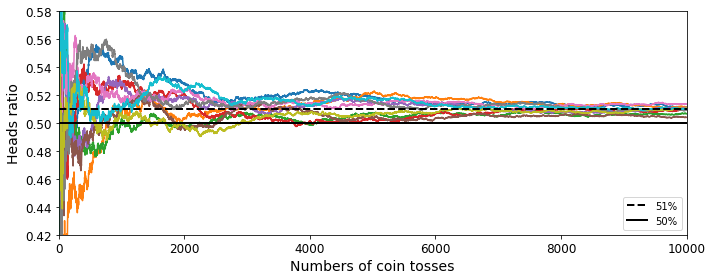

In [15]:
plt.figure(figsize = (10,4))
plt.plot(cumulative_heads_ratio)
plt.plot([0,10000],[0.51,0.51], 'k--', linewidth = 2, label = '51%')
plt.plot([0,10000],[0.5,0.5],'k-', linewidth = 2, label = '50%')
plt.xlabel("Numbers of coin tosses")
plt.ylabel("Heads ratio")
plt.legend(loc="lower right")
plt.axis([0,10000,0.42,0.58])
save_fig('law_of_large_numbers_plot')
plt.show()

- 1개의 시행만 plot

그림 저장: law_of_large_numbers_plot


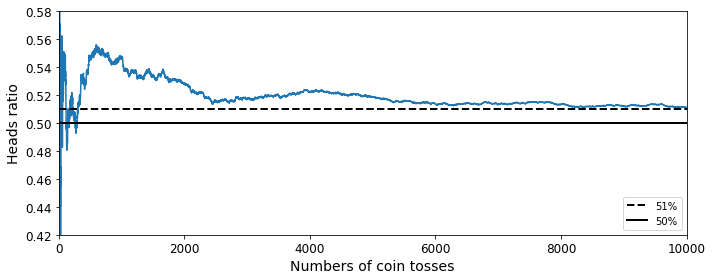

In [17]:
plt.figure(figsize = (10,4))
plt.plot(cumulative_heads_ratio[:,0])
plt.plot([0,10000],[0.51,0.51], 'k--', linewidth = 2, label = '51%')
plt.plot([0,10000],[0.5,0.5],'k-', linewidth = 2, label = '50%')
plt.xlabel("Numbers of coin tosses")
plt.ylabel("Heads ratio")
plt.legend(loc="lower right")
plt.axis([0,10000,0.42,0.58])
save_fig('law_of_large_numbers_plot')
plt.show()

In [37]:
from scipy.stats import binom

print(1- binom.cdf(499,1000,0.51)) # 1000번을 던졌을 때 앞면이 절반 이상 나올 확률

0.7467502275561786


- 이와 비슷하게 51% 정확도를 가진 1000개의 분류기로 앙상블 모델을 구축한다고 가정
- 가장 많은 클래스를 예측으로 삼는다면 75%의 정확도를 기대할 수 있음

In [39]:
from sklearn.model_selection import train_test_split
from sklearn.datasets import make_moons 

X,y = make_moons(n_samples = 500, noise = 0.30, random_state = 42)
X_train, X_test, y_train, y_test = train_test_split(X,y,random_state = 42)

In [42]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.ensemble import VotingClassifier #투표 기반 분류기
from sklearn.linear_model import LogisticRegression
from sklearn.svm import SVC

log_clf = LogisticRegression(solver = 'lbfgs', random_state = 42)
rnd_clf = RandomForestClassifier(n_estimators = 100, random_state = 42)
svm_clf = SVC(gamma = 'scale', random_state = 42)

voting_clf = VotingClassifier(
    estimators = [('lr', log_clf),('rf',rnd_clf),('svc',svm_clf)],
    voting = 'hard') # voting = 'hard'가 기본, 'soft'도 있음

In [43]:
voting_clf.fit(X_train,y_train)

VotingClassifier(estimators=[('lr', LogisticRegression(random_state=42)),
                             ('rf', RandomForestClassifier(random_state=42)),
                             ('svc', SVC(random_state=42))])

In [44]:
from sklearn.metrics import accuracy_score

for clf in (log_clf, rnd_clf, svm_clf, voting_clf) :
    clf.fit(X_train, y_train)
    y_pred = clf.predict(X_test)
    print(clf.__class__.__name__, accuracy_score(y_test,y_pred))

LogisticRegression 0.864
RandomForestClassifier 0.896
SVC 0.896
VotingClassifier 0.912


- 다시 훈련할 필요 없이 더 효율적인 방식으로 계산

In [47]:
for clf in voting_clf.estimators_ + [voting_clf] :
# 이미 voting_clf.estimators_ 속성에 로지스틱, 랜덤 포레스트, SVC객체가 리스트로 들어가있음
    print(clf.__class__.__name__, clf.score(X_test, y_test))

LogisticRegression 0.864
RandomForestClassifier 0.896
SVC 0.896
VotingClassifier 0.912


# 간접 투표
- 각 분류기의 predict_proba 메서드를 받아서 확률의 평균이 가장 큰 클래스 예측
- 클래스 예측 결과로 정하는 것이 아니라, 각 클래스의 확률의 평균으로 정하기 때문에 좀 더 정확하게 계산이 가능

In [48]:
log_clf = LogisticRegression(solver = 'lbfgs', random_state = 42)
rnd_clf = RandomForestClassifier(n_estimators = 100, random_state = 42)
svm_clf = SVC(gamma = 'scale', probability = True, random_state = 42)
# 서포트 벡터 머신은 기본적으로 확률값을 계산하지 않기 때문에 predict_proba 메서드를 제공하려면 probability = True
# 내부적으로 SVC 모델이 교차 검증을 수행하면서 확률값을 계산하기 때문에 속도가 다소 느려진다는 단점은 존재함

voting_clf = VotingClassifier(
    estimators = [('lr', log_clf),('rf',rnd_clf),('svc',svm_clf)],
    voting = 'soft')
voting_clf.fit(X_train, y_train)

VotingClassifier(estimators=[('lr', LogisticRegression(random_state=42)),
                             ('rf', RandomForestClassifier(random_state=42)),
                             ('svc', SVC(probability=True, random_state=42))],
                 voting='soft')

In [49]:
from sklearn.metrics import accuracy_score

for clf in (log_clf, rnd_clf, svm_clf, voting_clf) :
    clf.fit(X_train, y_train)
    y_pred = clf.predict(X_test)
    print(clf.__class__.__name__, accuracy_score(y_test,y_pred))

LogisticRegression 0.864
RandomForestClassifier 0.896
SVC 0.896
VotingClassifier 0.92


- 직접 투표 분류기의 정확도가 0.912였던 것과 비교하면 간접 투표 분류기의 정확도는 0.92로 약간 증가했음을 알 수 있음

# 배깅 앙상블
- bootstrap aggregating의 줄임말
- 붓스트랩을 사용한 분류기

- 훈련 세트에서 일부 데이터를 뽑아서 서브 분류기를 훈련하고, 또 새로운 데이터를 뽑아서 서브 분류기를 훈련하는 방식
- 데이터셋의 무작위성을 확보 > 모델의 성능이 높아질 수 있음

In [83]:
from sklearn.ensemble import BaggingClassifier
from sklearn.tree import DecisionTreeClassifier

bag_clf = BaggingClassifier(
    DecisionTreeClassifier(random_state = 42), n_estimators = 500,
    max_samples = 100, bootstrap = True, random_state = 42)  # 100개씩 샘플링하면서 분류기 훈련하는 과정 500번 수행
bag_clf.fit(X_train,y_train)
y_pred = bag_clf.predict(X_test)

- bootstrap = False로 지정하는 경우 페이스팅(pasting)이라고 함

In [84]:
from sklearn.metrics import accuracy_score
print(accuracy_score(y_test,y_pred))

0.904


- 개별 결정 트리와 비교

In [85]:
tree_clf = DecisionTreeClassifier(random_state = 42)
tree_clf.fit(X_train,y_train)
y_pred = tree_clf.predict(X_test)
print(accuracy_score(y_test,y_pred))

0.856


- 결정 경계 출력

In [86]:
from matplotlib.colors import ListedColormap

def plot_decision_boundary(clf,X,y,axes = [-1.5,2.45, -1, 1.5], alpha = 0.5, contour = True) :
    x1s = np.linspace(axes[0], axes[1], 100)
    x2s = np.linspace(axes[2], axes[3], 100)
    x1, x2 = np.meshgrid(x1s,x2s)
    X_new = np.c_[x1.ravel(), x2.ravel()]
    y_pred = clf.predict(X_new).reshape(x1.shape)
    custom_cmap = ListedColormap(['#fafab0','#9898ff','#a0faa0'])
    plt.contourf(x1,x2,y_pred, alpha = 0.3, cmap = custom_cmap)
    if contour :
        custom_cmap2 = ListedColormap(['#7d7d58','#4c4c7f','#507d50'])
        plt.contour(x1,x2,y_pred, cmap = custom_cmap2, alpha = 0.8)
    plt.plot(X[:,0][y==0], X[:,1][y==0], 'yo', alpha = alpha)
    plt.plot(X[:,0][y==1], X[:,1][y==1], 'bs', alpha = alpha)
    plt.axis(axes)
    plt.xlabel(r"$x_1$", fontsize = 18)
    plt.ylabel(r"$x_2$", fontsize = 18, rotation = 0)

그림 저장: decision_tree_without_and_with_bagging_plot


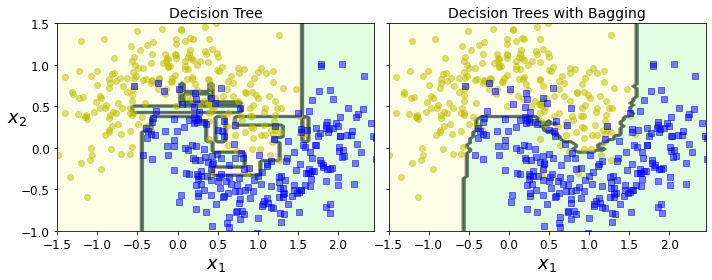

In [87]:
fix, axes = plt.subplots(ncols = 2, figsize = (10,4), sharey = True)
plt.sca(axes[0])
plot_decision_boundary(tree_clf,X,y)
plt.title("Decision Tree", fontsize = 14)
plt.sca(axes[1])
plot_decision_boundary(bag_clf,X,y)
plt.title("Decision Trees with Bagging", fontsize=  14)
plt.ylabel("")
save_fig("decision_tree_without_and_with_bagging_plot")
plt.show()


- 결정 트리가 하나인 경우 복잡하고 일반화가 덜 된 것처럼 보임(과대적합)
- 앙상블 모델의 경우 부드럽고 일반화가 잘 된 결정 경계가 만들어짐

# 랜덤 포레스트
- 가장 대표적이고 많이 사용되는 앙상블 모델

In [88]:
bag_clf = BaggingClassifier(
    DecisionTreeClassifier(max_leaf_nodes = 16, random_state = 42), 
    n_estimators = 500, max_samples = 1.0, bootstrap = True, random_state = 42 )

In [89]:
bag_clf.fit(X_train,y_train)
y_pred = bag_clf.predict(X_test)

In [90]:
# 속도가 느리면 n_jobs = -1 이용해서 CPU 최대로 이용
from sklearn.ensemble import RandomForestClassifier

rnd_clf = RandomForestClassifier(n_estimators = 500, max_leaf_nodes = 16, random_state = 42 )
rnd_clf.fit(X_train,y_train)
y_pred_rf = rnd_clf.predict(X_test)

In [91]:
np.sum(y_pred == y_pred_rf) / len(y_pred) #예측 결과 거의 동일

0.952

- 특성 중요도 제공

In [92]:
from sklearn.datasets import load_iris
iris = load_iris()
rnd_clf = RandomForestClassifier(n_estimators = 500, random_state = 42)
rnd_clf.fit(iris.data, iris.target)
for name, score in zip(iris.feature_names, rnd_clf.feature_importances_) :
    print(name, score)

sepal length (cm) 0.11249225099876375
sepal width (cm) 0.02311928828251033
petal length (cm) 0.4410304643639577
petal width (cm) 0.4233579963547682


In [94]:
rnd_clf.feature_importances_ # 위의 결과와 동일

array([0.11249225, 0.02311929, 0.44103046, 0.423358  ])

#### 결정 트리를 붓스트랩을 이용해서 수동으로 만들어보기

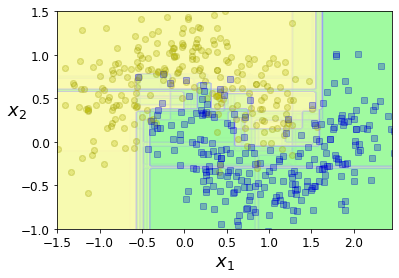

In [97]:
plt.figure(figsize = (6,4))

for i in range(15) : 
    tree_clf = DecisionTreeClassifier(max_leaf_nodes = 16, random_state = 42 + i)
    indices_with_replacement = np.random.randint(0,len(X_train),len(X_train))
    tree_clf.fit(X[indices_with_replacement], y[indices_with_replacement])
    plot_decision_boundary(tree_clf,X,y,axes=[-1.5,2.45,-1,1.5], alpha = 0.02, contour = False)
    
plt.show()

- 랜덤 포레스트를 통해서 똑같이 만들 수 있음

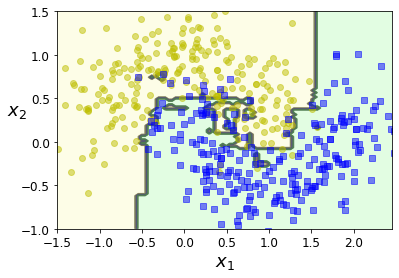

In [98]:
rf = RandomForestClassifier(n_estimators = 15, random_state = 42)
rf.fit(X_train,y_train)
plot_decision_boundary(rf,X,y,axes = [ -1.5,2.45,-1,1.5])

# oob 평가
- 모델 훈련에 참여하지 않는 샘플이 생길 수 있음(평균적으로 37% 정도)
- 훈련에 사용되지 않은 샘플을 검증 세트처럼 이용할 수 있음
 - 검증 세트를 따로 떼어내지 않고도 score를 측정할 수 있음

In [109]:
bag_clf = BaggingClassifier(
    DecisionTreeClassifier(random_state=42), n_estimators=500,
    bootstrap=True, oob_score=True, random_state=40)
bag_clf.fit(X_train, y_train)
bag_clf.oob_score_

0.8986666666666666

In [104]:
bag_clf.oob_decision_function_

array([[0.32275132, 0.67724868],
       [0.34117647, 0.65882353],
       [1.        , 0.        ],
       [0.        , 1.        ],
       [0.        , 1.        ],
       [0.09497207, 0.90502793],
       [0.31147541, 0.68852459],
       [0.01754386, 0.98245614],
       [0.97109827, 0.02890173],
       [0.97765363, 0.02234637],
       [0.74404762, 0.25595238],
       [0.        , 1.        ],
       [0.7173913 , 0.2826087 ],
       [0.85026738, 0.14973262],
       [0.97222222, 0.02777778],
       [0.0625    , 0.9375    ],
       [0.        , 1.        ],
       [0.97837838, 0.02162162],
       [0.94642857, 0.05357143],
       [1.        , 0.        ],
       [0.01704545, 0.98295455],
       [0.39473684, 0.60526316],
       [0.88700565, 0.11299435],
       [1.        , 0.        ],
       [0.97790055, 0.02209945],
       [0.        , 1.        ],
       [0.99428571, 0.00571429],
       [1.        , 0.        ],
       [0.        , 1.        ],
       [0.62569832, 0.37430168],
       [0.

In [107]:
from sklearn.metrics import accuracy_score
y_pred = bag_clf.predict(X_test)
accuracy_score(y_test,y_pred)

0.912

# 특성 중요도

In [110]:
from sklearn.datasets import fetch_openml

mnist = fetch_openml('mnist_784', version = 1)
mnist.target = mnist.target.astype(np.uint8)

In [111]:
rnd_clf = RandomForestClassifier(n_estimators = 100, random_state = 42)
rnd_clf.fit(mnist.data, mnist.target)

RandomForestClassifier(random_state=42)

In [115]:
def plot_digit(data) :
    image = data.reshape(28,28)
    plt.imshow(image, cmap = mpl.cm.hot,
               interpolation = 'nearest')
    plt.axis('off')

그림 저장: mnist_feature_importance_plot


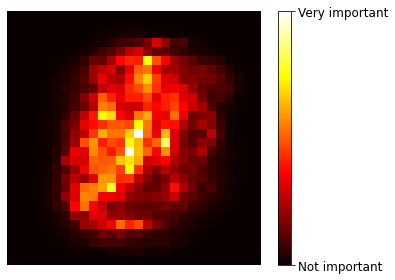

In [117]:
plot_digit(rnd_clf.feature_importances_)

cbar = plt.colorbar(ticks = [rnd_clf.feature_importances_.min(), rnd_clf.feature_importances_.max()])
cbar.ax.set_yticklabels(['Not important','Very important'])

save_fig('mnist_feature_importance_plot')
plt.show()

# 에이다 부스트
- 이전의 예측기를 보완하는 새로운 예측기를 만드는 방법은 이전 모델이 과소적합했던 훈련 샘플의 가중치를 더 높이는 것
- 그렇게 하면 새로운 예측기는 학습하기 어려운 샘플에 점점 더 맞춰지게 됨

- 예를 들어, 에이다부스트 분류기를 만들 때 먼저 알고리즘이 기반이 되는 첫 번째 분류기(ex. 결정 트리)를 훈련 세트에서 훈련시키고 예측
- 그 다음에 알고리즘이 잘못 분류된 훈련 샘플의 가중치를 상대적으로 높임
- 두 번째 분류기를 업데이트된 가중치를 사용하해 훈련 세트에서 훈련하고 다시 예측
- 그 다음에 다시 가중치를 업데이트하는 식으로 계속해서 진행

In [119]:
from sklearn.ensemble import AdaBoostClassifier
# AdaBoostRegressor(회귀 모델도 존재) --> DecisionTreeRegressor 이용 (기본 트리로 max_depth = 3 이용)
ada_clf = AdaBoostClassifier(
    DecisionTreeClassifier(max_depth=1), n_estimators= 200,  # 분류 모델에서는 max_depth = 1 주로 이용
    algorithm = 'SAMME.R', learning_rate = 0.5, random_state = 42) # 'SAMME.R'이 기본, 'SAMME'등 변경 가능 # learning_rate 기본값 1
ada_clf.fit(X_train,y_train)

AdaBoostClassifier(base_estimator=DecisionTreeClassifier(max_depth=1),
                   learning_rate=0.5, n_estimators=200, random_state=42)

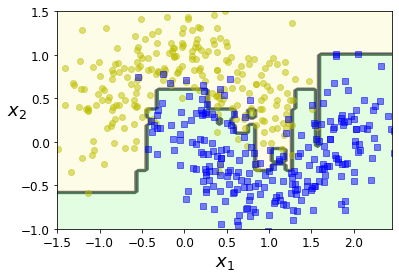

In [120]:
plot_decision_boundary(ada_clf,X,y)

- learning_rate에 따른 차이를 보기 위한 plot

그림 저장: boosting_plot


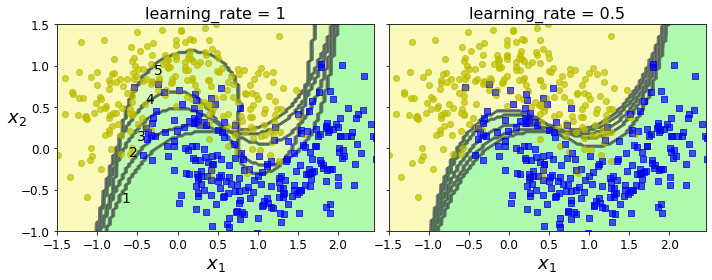

In [126]:
m = len(X_train)

fix, axes = plt.subplots(ncols = 2, figsize = (10,4), sharey = True)
for subplot, learning_rate in ((0,1),(1,0.5)):
    sample_weights = np.ones(m)
    plt.sca(axes[subplot])
    for i in range(5):
        svm_clf = SVC(kernel = 'rbf' ,C = 0.05, gamma = 'scale', random_state = 42)
        svm_clf.fit(X_train,y_train, sample_weight = sample_weights)
        y_pred = svm_clf.predict(X_train)
        sample_weights[y_pred != y_train] *= (1 + learning_rate)
        plot_decision_boundary(svm_clf, X, y, alpha = 0.2)
        plt.title("learning_rate = {}".format(learning_rate), fontsize = 16)
    if subplot == 0 :
        plt.text(-0.7,-0.65,"1",fontsize = 14)
        plt.text(-0.6,-0.10,"2",fontsize = 14)
        plt.text(-0.5,0.10,"3",fontsize = 14)
        plt.text(-0.4,0.55,"4",fontsize = 14)
        plt.text(-0.3,0.90,"5",fontsize = 14)
    else:
        plt.ylabel("")
        
save_fig('boosting_plot')
plt.show()

In [128]:
list(m for m in dir(ada_clf) if not m.startswith("_") and m.endswith("_"))

['base_estimator_',
 'classes_',
 'estimator_errors_',
 'estimator_weights_',
 'estimators_',
 'feature_importances_',
 'n_classes_',
 'n_features_in_']

- 분류기의 가중치(샘플 X)

In [129]:
ada_clf.estimator_weights_

array([1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.,
       1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.,
       1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.,
       1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.,
       1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.,
       1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.,
       1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.,
       1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.,
       1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.,
       1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.,
       1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.,
       1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.])

- SAMME.R 대신에 SAMME를 사용하면 다른 가중치를 얻을 수 있음

In [131]:
ada_clf2 = AdaBoostClassifier(
    DecisionTreeClassifier(max_depth=1), n_estimators= 200,  # 분류 모델에서는 max_depth = 1 주로 이용
    algorithm = 'SAMME', learning_rate = 0.5, random_state = 42) # 'SAMME.R'이 기본, 'SAMME'등 변경 가능 # learning_rate 기본값 1
ada_clf2.fit(X_train,y_train)

AdaBoostClassifier(algorithm='SAMME',
                   base_estimator=DecisionTreeClassifier(max_depth=1),
                   learning_rate=0.5, n_estimators=200, random_state=42)

In [132]:
ada_clf2.estimator_weights_

array([0.75367002, 0.54049801, 0.4224443 , 0.48647654, 0.31654854,
       0.379218  , 0.30032211, 0.31846391, 0.27158952, 0.17926049,
       0.31058992, 0.19282219, 0.29419055, 0.22303041, 0.12939442,
       0.26037109, 0.15927339, 0.25946793, 0.22941444, 0.1422021 ,
       0.22361957, 0.1549239 , 0.11170221, 0.19674255, 0.11689374,
       0.09087907, 0.09939409, 0.0699826 , 0.08082521, 0.09634825,
       0.22996886, 0.1964156 , 0.11396743, 0.20020455, 0.13475059,
       0.0981953 , 0.16731037, 0.10013918, 0.07909107, 0.19407372,
       0.09877874, 0.22921439, 0.10128315, 0.05559778, 0.07570118,
       0.14706034, 0.12596329, 0.05130632, 0.14715971, 0.08764181,
       0.07043982, 0.17506428, 0.08886183, 0.04443092, 0.13022963,
       0.10088737, 0.19500586, 0.08300459, 0.16257046, 0.06498438,
       0.05739202, 0.07403357, 0.04395452, 0.15326153, 0.08635956,
       0.06528596, 0.12361461, 0.07085821, 0.05691824, 0.06132247,
       0.04090863, 0.04972253, 0.04364593, 0.10235768, 0.08758

# 그레이디언트 부스팅
- 에이다부스트처럼 앙상블에 이전까지의 오차를 보정하도록 예측기를 순차적으로 추가
- 하지만 에이다부스트처럼 반복마다 샘플의 가중치를 수정하는 대신 이전 예측기가 만든 잔여 오차에 새로운 예측기 학습

In [136]:
np.random.seed(42)
X = np.random.rand(100,1) - 0.5 # -0.5 ~ 0.5에서 샘플 균등하게 추출
y = 3 * X[:,0] ** 2 + 0.05 * np.random.randn(100) # y = 3x^2 

In [137]:
from sklearn.tree import DecisionTreeRegressor 

tree_reg1 = DecisionTreeRegressor(max_depth = 2, random_state = 42)
tree_reg1.fit(X,y)

DecisionTreeRegressor(max_depth=2, random_state=42)

In [138]:
y2 = y - tree_reg1.predict(X) # residual
tree_reg2 = DecisionTreeRegressor(max_depth = 2, random_state = 42)
tree_reg2.fit(X,y2)
# 타깃이 오차가 된 모델

DecisionTreeRegressor(max_depth=2, random_state=42)

In [140]:
y3 = y2 - tree_reg2.predict(X)
tree_reg3 = DecisionTreeRegressor(max_depth = 2, random_state = 42)
tree_reg3.fit(X,y3)

DecisionTreeRegressor(max_depth=2, random_state=42)

- 3개의 트리를 포함하는 앙상블 모델 훈련
- 새로운 샘플에 대한 예측을 만들려면 모든 트리의 예측을 더하면 됨

In [141]:
X_new = np.array([[0.8]])

In [143]:
y_pred = sum(tree.predict(X_new) for tree in (tree_reg1, tree_reg2, tree_reg3))

In [144]:
y_pred

array([0.75026781])

In [158]:
def plot_predictions(regressors, X, y, axes, label = None, style = 'r-', data_style = 'b.', data_label = None):
    x1 = np.linspace(axes[0], axes[1], 500)
    y_pred = sum(regressor.predict(x1.reshape(-1,1)) for regressor in regressors)
    plt.plot(X[:,0], y ,data_style, label = data_label)
    plt.plot(x1, y_pred, style, linewidth = 2, label = label)
    if label or data_label :
        plt.legend(loc = 'upper center', fontsize = 16)
    plt.axis(axes)
    

그림 저장: gradient_boosting_plot


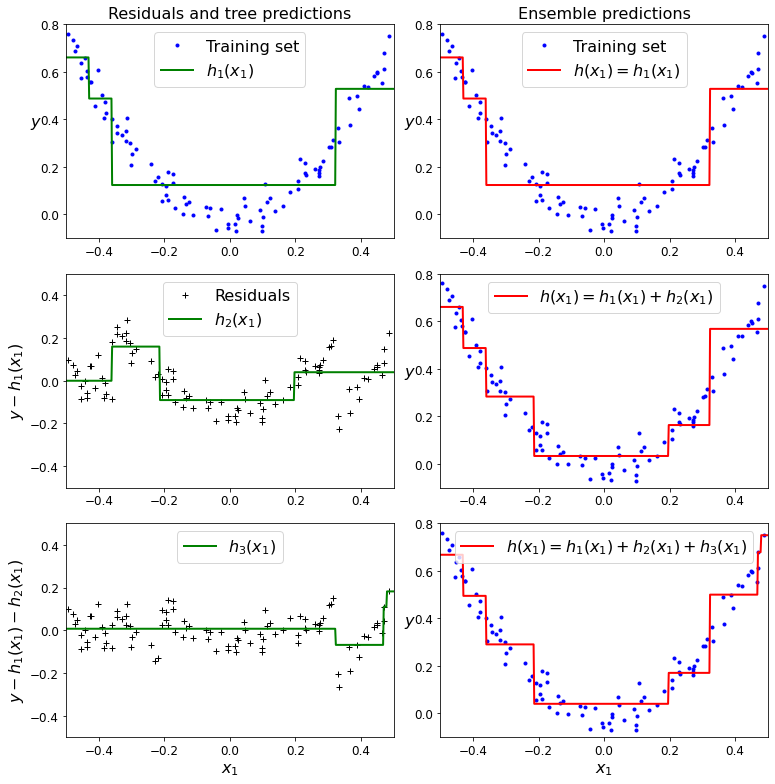

In [159]:
plt.figure(figsize=(11,11))

plt.subplot(321)
plot_predictions([tree_reg1], X, y, axes=[-0.5, 0.5, -0.1, 0.8], label="$h_1(x_1)$", style="g-", data_label="Training set")
plt.ylabel("$y$", fontsize=16, rotation=0)
plt.title("Residuals and tree predictions", fontsize=16)

plt.subplot(322)
plot_predictions([tree_reg1], X, y, axes=[-0.5, 0.5, -0.1, 0.8], label="$h(x_1) = h_1(x_1)$", data_label="Training set")
plt.ylabel("$y$", fontsize=16, rotation=0)
plt.title("Ensemble predictions", fontsize=16)

plt.subplot(323)
plot_predictions([tree_reg2], X, y2, axes=[-0.5, 0.5, -0.5, 0.5], label="$h_2(x_1)$", style="g-", data_style="k+", data_label="Residuals")
plt.ylabel("$y - h_1(x_1)$", fontsize=16)

plt.subplot(324)
plot_predictions([tree_reg1, tree_reg2], X, y, axes=[-0.5, 0.5, -0.1, 0.8], label="$h(x_1) = h_1(x_1) + h_2(x_1)$")
plt.ylabel("$y$", fontsize=16, rotation=0)

plt.subplot(325)
plot_predictions([tree_reg3], X, y3, axes=[-0.5, 0.5, -0.5, 0.5], label="$h_3(x_1)$", style="g-", data_style="k+")
plt.ylabel("$y - h_1(x_1) - h_2(x_1)$", fontsize=16)
plt.xlabel("$x_1$", fontsize=16)

plt.subplot(326)
plot_predictions([tree_reg1, tree_reg2, tree_reg3], X, y, axes=[-0.5, 0.5, -0.1, 0.8], label="$h(x_1) = h_1(x_1) + h_2(x_1) + h_3(x_1)$")
plt.xlabel("$x_1$", fontsize=16)
plt.ylabel("$y$", fontsize=16, rotation=0)

save_fig("gradient_boosting_plot")
plt.show()

- 오차에 대해서 학습하기 때문에 에이다부스트와 다르게 그레이디언트 부스팅은 기반 분류기가 DecisionTreeRegressor

In [161]:
from sklearn.ensemble import GradientBoostingRegressor

gbrt = GradientBoostingRegressor(max_depth = 2, n_estimators = 3, loss = 'ls', learning_rate = 1.0, random_state = 42)
gbrt.fit(X,y)
# GradientBoostingClassifier의 경우에는 loss = 'deviance'

GradientBoostingRegressor(learning_rate=1.0, max_depth=2, n_estimators=3,
                          random_state=42)

In [162]:
# n_estimator = 200으로 설정 (트리 개수 200개 --> 속도가 느려짐)
gbrt_slow = GradientBoostingRegressor(max_depth = 2, n_estimators = 200, learning_rate = 0.1, random_state = 42)
gbrt_slow.fit(X,y)

GradientBoostingRegressor(max_depth=2, n_estimators=200, random_state=42)

- gbrt, gbrt_slow 두 가지 모델 plot

그림 저장: gbrt_learning_rate_plot


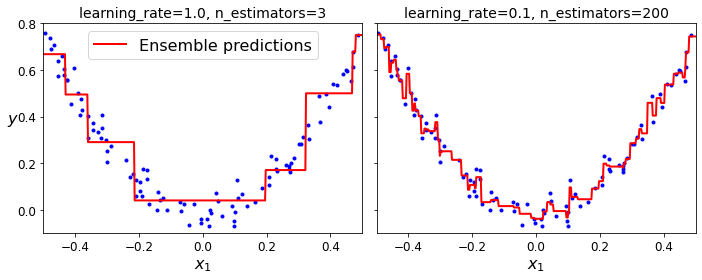

In [163]:
fix, axes = plt.subplots(ncols=2, figsize=(10,4), sharey=True)

plt.sca(axes[0])
plot_predictions([gbrt], X, y, axes=[-0.5, 0.5, -0.1, 0.8], label="Ensemble predictions")
plt.title("learning_rate={}, n_estimators={}".format(gbrt.learning_rate, gbrt.n_estimators), fontsize=14)
plt.xlabel("$x_1$", fontsize=16)
plt.ylabel("$y$", fontsize=16, rotation=0)

plt.sca(axes[1])
plot_predictions([gbrt_slow], X, y, axes=[-0.5, 0.5, -0.1, 0.8])
plt.title("learning_rate={}, n_estimators={}".format(gbrt_slow.learning_rate, gbrt_slow.n_estimators), fontsize=14)
plt.xlabel("$x_1$", fontsize=16)

save_fig("gbrt_learning_rate_plot")
plt.show()

- 오른쪽 plot이 다소 과대적합 되었다고 볼 수 있음

# 조기 종료를 사용한 그레이디언트 부스팅

In [168]:
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error 

X_train, X_val, y_train, y_val = train_test_split(X,y,random_state = 49)

gbrt = GradientBoostingRegressor(max_depth = 2, n_estimators = 120, random_state = 42)
gbrt.fit(X_train, y_train)

errors = [mean_squared_error(y_val, y_pred)
          for y_pred in gbrt.staged_predict(X_val)]
bst_n_estimators = np.argmin(errors) + 1

gbrt_best = GradientBoostingRegressor(max_depth = 2, n_estimators = bst_n_estimators, random_state = 42)
gbrt_best.fit(X_train, y_train)



GradientBoostingRegressor(max_depth=2, n_estimators=56, random_state=42)

In [169]:
min_error = np.min(errors)

In [170]:
min_error

0.002712853325235463

그림 저장: early_stopping_gbrt_plot


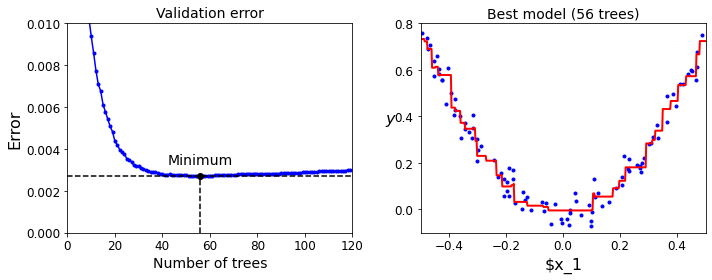

In [175]:
plt.figure(figsize = (10,4))

plt.subplot(121)
plt.plot(errors, 'b.-')
plt.plot([bst_n_estimators, bst_n_estimators],[0, min_error], 'k--')
plt.plot([0,120],[min_error,min_error],'k--')
plt.plot(bst_n_estimators, min_error, 'ko')
plt.text(bst_n_estimators, min_error*1.2, 'Minimum', ha = 'center', fontsize = 14)
plt.axis([0,120,0,0.01])
plt.xlabel('Number of trees')
plt.ylabel('Error', fontsize = 16)
plt.title('Validation error', fontsize = 14)

plt.subplot(122)
plot_predictions([gbrt_best], X, y, axes = [-0.5,0.5,-0.1,0.8])
plt.title('Best model (%d trees)' % bst_n_estimators, fontsize = 14)
plt.ylabel("$y$", fontsize = 16, rotation = 0)
plt.xlabel('$x_1', fontsize = 16)

save_fig('early_stopping_gbrt_plot')
plt.show()

### 조기 종료 이용하는 또 다른 방법은 warm_start 매개변수 이용

In [176]:
gbrt = GradientBoostingRegressor(max_depth = 2, warm_start = True, random_state = 42)

min_val_error = float('inf')
error_going_up = 0 
for n_estimators in range(1,120) : 
    gbrt.n_estimators = n_estimators 
    gbrt.fit(X_train, y_train)
    y_pred = gbrt.predict(X_val)
    val_error = mean_squared_error(y_val , y_pred)
    if val_error < min_val_error:
        min_val_error = val_error
        error_going_up = 0
    else:
        error_going_up += 1 
        if error_going_up == 5 :
            break

In [177]:
print(gbrt.n_estimators)

61


In [180]:
print('Minimum validation MSE : ', min_val_error)

Minimum validation MSE :  0.002712853325235463


# XGBoost 
- 히스토그램 기반의 부스팅 알고리즘

In [182]:
try:
    import xgboost
except ImportError as ex:
    print("에러: xgboost 라이브러리가 설치되지 않았습니다.")
    xgboost = None

In [211]:
if xgboost is not None : 
    xgb_reg = xgboost.XGBRegressor(random_state = 42, n_estimators = 100, max_depth = 3)
    xgb_reg.fit(X_train, y_train)
    y_pred = xgb_reg.predict(X_val)
    val_error = mean_squared_error(y_val, y_pred)
    print("validation MSE : ", val_error)

validation MSE :  0.003582937165181248


In [213]:
if xgboost is not None:  # 책에 없음
    xgb_reg.fit(X_train, y_train,
                eval_set=[(X_val, y_val)], early_stopping_rounds=2)
    y_pred = xgb_reg.predict(X_val)
    val_error = mean_squared_error(y_val, y_pred)  
    print("Validation MSE:", val_error)            

[0]	validation_0-rmse:0.22446
[1]	validation_0-rmse:0.15997
[2]	validation_0-rmse:0.11983
[3]	validation_0-rmse:0.09086
[4]	validation_0-rmse:0.07125
[5]	validation_0-rmse:0.05978
[6]	validation_0-rmse:0.05300
[7]	validation_0-rmse:0.05206
[8]	validation_0-rmse:0.05171
[9]	validation_0-rmse:0.05162
[10]	validation_0-rmse:0.05124
[11]	validation_0-rmse:0.05241
Validation MSE: 0.002625700976300432


- xgboost 성능 측정

In [214]:
%timeit xgboost.XGBRegressor().fit(X_train, y_train) if xgboost is not None else None

33.7 ms ± 770 µs per loop (mean ± std. dev. of 7 runs, 10 loops each)


In [215]:
%timeit GradientBoostingRegressor().fit(X_train, y_train)

20.1 ms ± 2.24 ms per loop (mean ± std. dev. of 7 runs, 100 loops each)


# lightgbm

In [208]:
from lightgbm import LGBMRegressor

lgb_reg = LGBMRegressor(random_state = 42)
lgb_reg.fit(X_train, y_train)

y_pred = lgb_reg.predict(X_val)
val_error = mean_squared_error(y_val, y_pred)
val_error

0.01777549654697777

In [216]:
%timeit LGBMRegressor().fit(X_train,y_train)

7.96 ms ± 724 µs per loop (mean ± std. dev. of 7 runs, 100 loops each)
